In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

Local_path='/home/jmdeloui/STL_dev/STL_main'
sys.path.append(Local_path)

from STL_Healpix_Kernel_Torch import STL_Healpix_Kernel_Torch as DataClass
from ST_Operator import ST_Operator as SO
from Synthesis import optimize_scattering_LBFGS

In [2]:
nside=32

im=np.random.rand(12*nside**2)
data=DataClass(im)

# test wavelet computation

/home/jmdeloui/miniconda3/envs/py311/lib/python3.11/site-packages/healpy/projector.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  img[w] = mpix


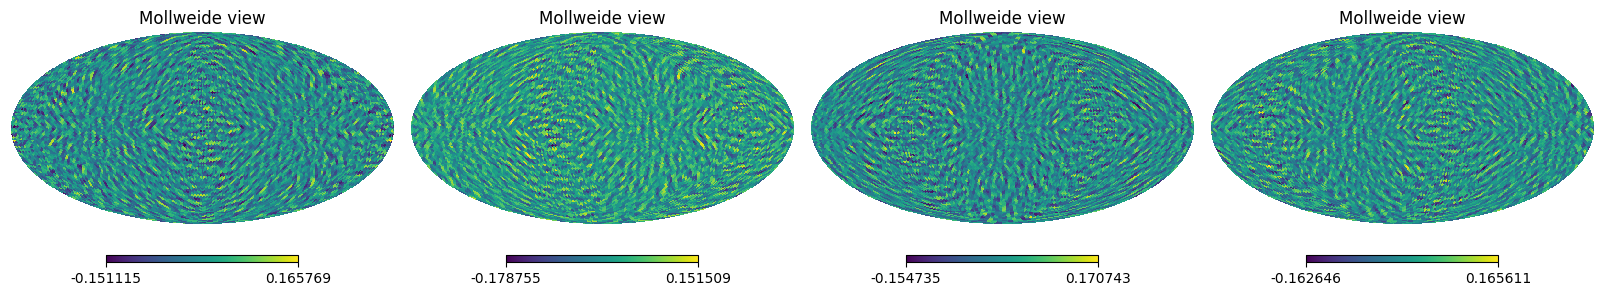

In [3]:
w_op=data.get_wavelet_op()

w_data = w_op.apply(data,0).array

plt.figure(figsize=(16,6))
for k in range(4):
    hp.mollview(w_data[k].cpu().numpy(),nest=True,hold=False,sub=(1,4,1+k))

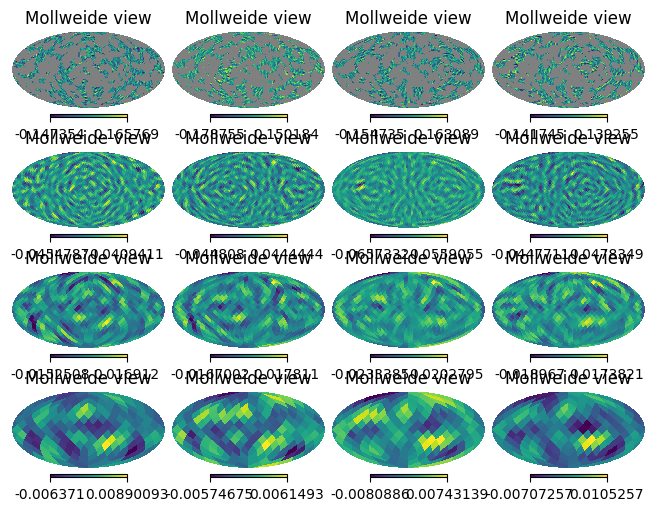

In [4]:
tmp=im.copy()
tmp[(np.random.rand(300)*12*nside**2).astype('int')]=np.nan

def unan(x):
    x[np.isnan(x)]=hp.UNSEEN
    return x
l_data=DataClass(tmp)

for j in range(4):
    w_data = w_op.apply(l_data,j).array
    for k in range(4):
        hp.mollview(unan(w_data[k].cpu().numpy()),nest=True,hold=False,sub=(4,4,1+k+4*j))
    
    #l_data=w_op.apply_smooth(l_data,copy=True)
    l_data=w_op.nandownsample(l_data,j+1)

In [5]:
from ST_Operator import ST_Operator as SO

l_data=DataClass(im)

st_op=SO(l_data)

st_data = st_op.apply(l_data)
st_data_nan = st_op.apply(DataClass(tmp),use_NaN=True)

/home/jmdeloui/miniconda3/envs/py311/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jmdeloui/miniconda3/envs/py311/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


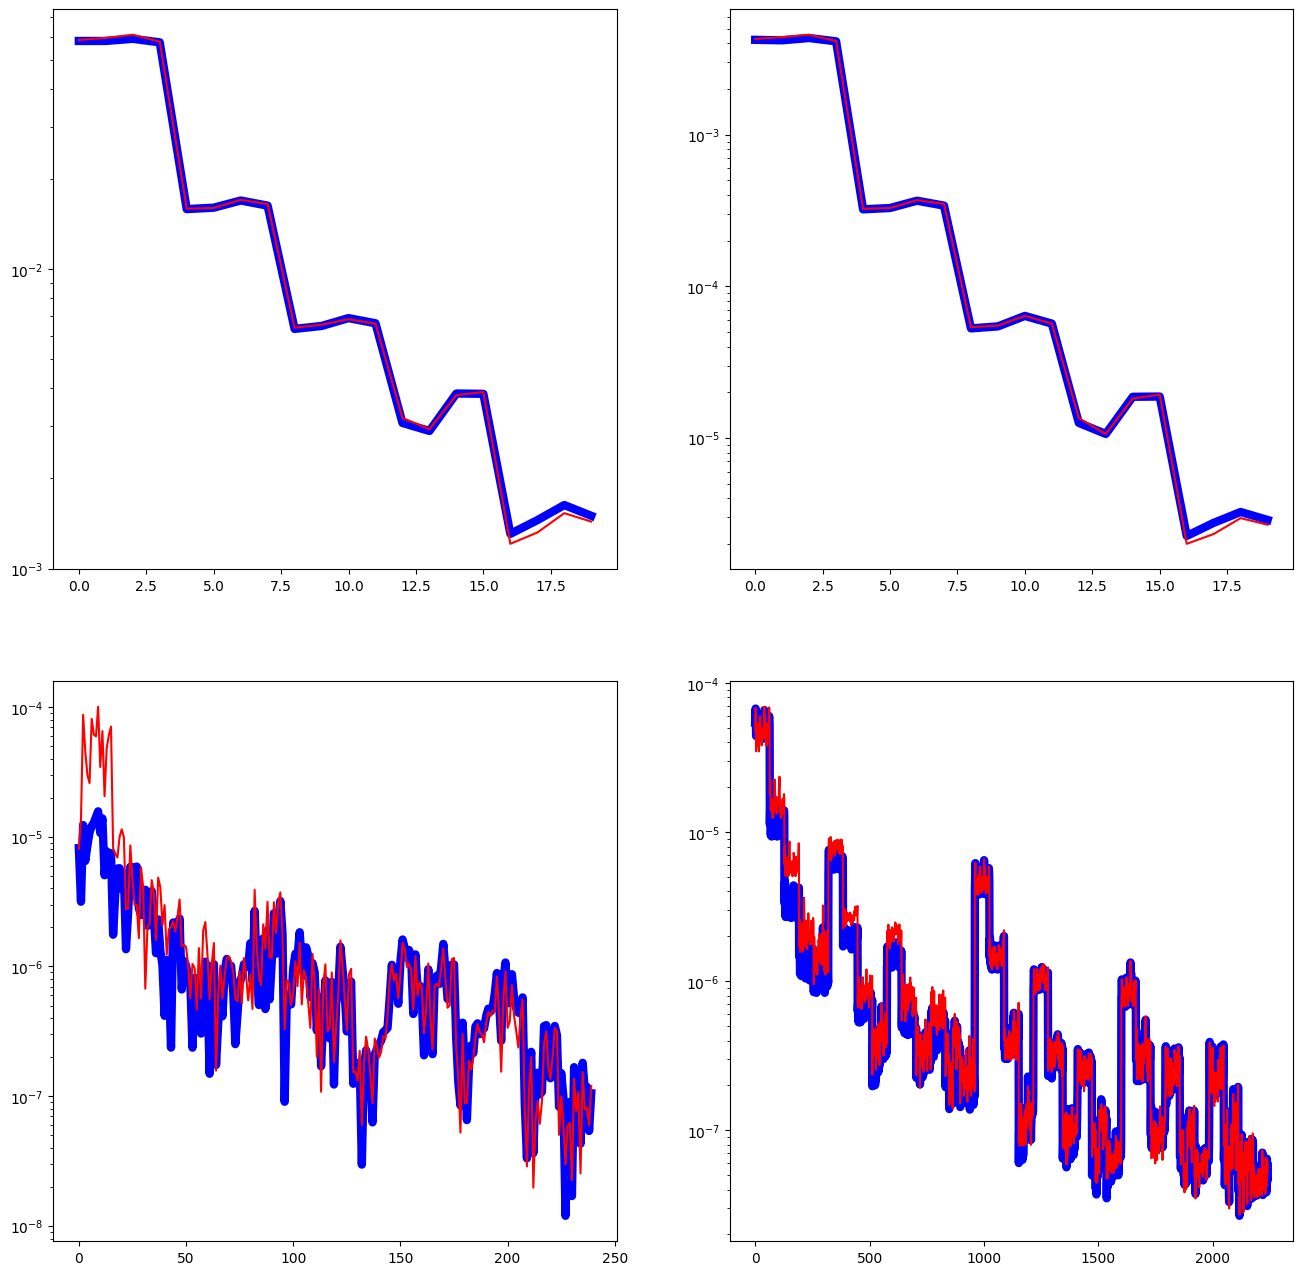

In [6]:
plt.figure(figsize=(16,16))
plt.subplot(2,2,1)
plt.plot(st_data.S1.cpu().numpy().flatten(),color='b',lw=6)
plt.plot(st_data_nan.S1.cpu().numpy().flatten(),color='r')
plt.yscale('log')
plt.subplot(2,2,2)
plt.plot(st_data.S2.cpu().numpy().flatten(),color='b',lw=6)
plt.plot(st_data_nan.S2.cpu().numpy().flatten(),color='r')
plt.yscale('log')
def r_nan(x):
    return x[np.isfinite(x)]
plt.subplot(2,2,3)
plt.plot(r_nan(st_data.S3.abs().cpu().numpy().flatten()),color='b',lw=6)
plt.plot(r_nan(st_data_nan.S3.abs().cpu().numpy().flatten()),color='r')
plt.yscale('log')
plt.subplot(2,2,4)
plt.plot(r_nan(st_data.S4.cpu().numpy().flatten()),color='b',lw=6)
plt.plot(r_nan(st_data_nan.S4.cpu().numpy().flatten()),color='r')
plt.yscale('log')

# do synthesis

In [7]:
st_data = st_op.apply(l_data)
st_data_norm = st_op.apply(l_data,norm='store_ref')

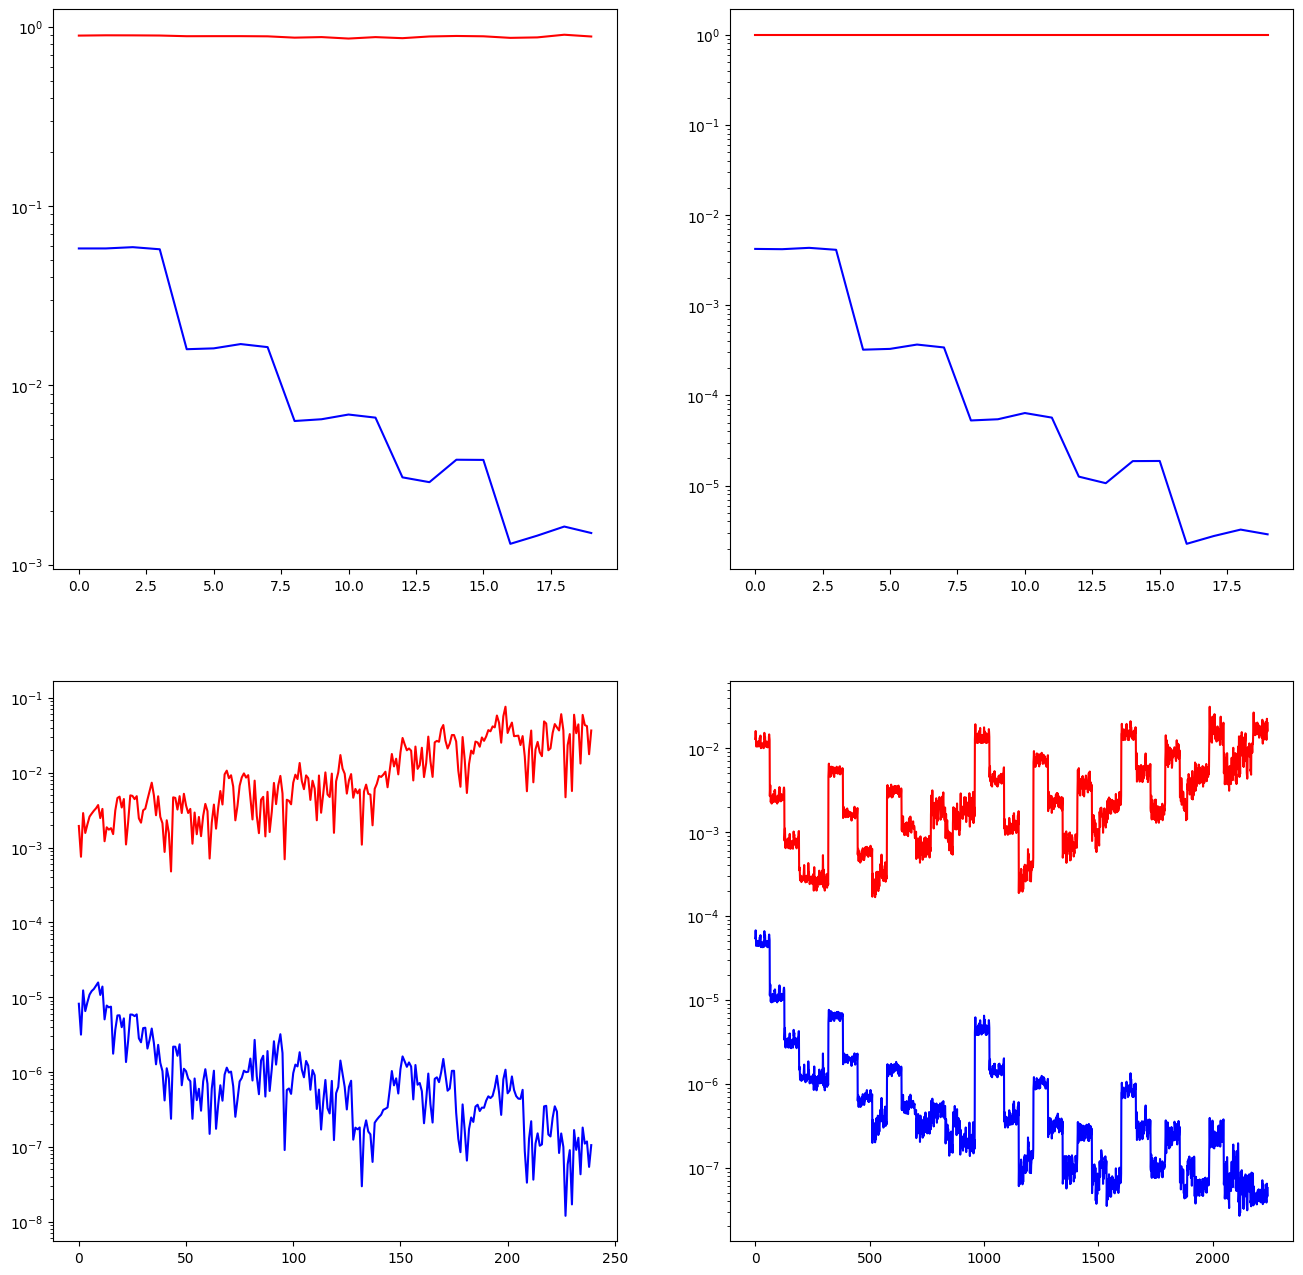

In [8]:
plt.figure(figsize=(16,16))
plt.subplot(2,2,1)
plt.plot(st_data.S1.cpu().numpy().flatten(),color='b')
plt.plot(st_data_norm.S1.cpu().numpy().flatten(),color='r')
plt.yscale('log')
plt.subplot(2,2,2)
plt.plot(st_data.S2.cpu().numpy().flatten(),color='b')
plt.plot(st_data_norm.S2.cpu().numpy().flatten(),color='r')
plt.yscale('log')
def r_nan(x):
    return x[np.isfinite(x)]
plt.subplot(2,2,3)
plt.plot(r_nan(st_data.S3.abs().cpu().numpy().flatten()),color='b')
plt.plot(r_nan(st_data_norm.S3.abs().cpu().numpy().flatten()),color='r')
plt.yscale('log')
plt.subplot(2,2,4)
plt.plot(r_nan(st_data.S4.cpu().numpy().flatten()),color='b')
plt.plot(r_nan(st_data_norm.S4.cpu().numpy().flatten()),color='r')
plt.yscale('log')

# do synthesis

In [9]:
heal_im=np.load(Local_path+'/Certif_Healpix_Kernel_Torch/Test_Heal_LSS.npy')

nside=32
heal_im = np.mean(heal_im.reshape(12*nside**2,heal_im.shape[0]//(12*nside**2)),1)

data = DataClass(heal_im)
w_op = data.get_wavelet_op()

#Build the smooth version
target = w_op.apply_smooth(data).array.cpu().numpy()

nan_target = target.copy()

nan_target[(np.random.rand(300)*12*nside**2).astype('int')]=np.nan
nan_target[56:96]=np.nan

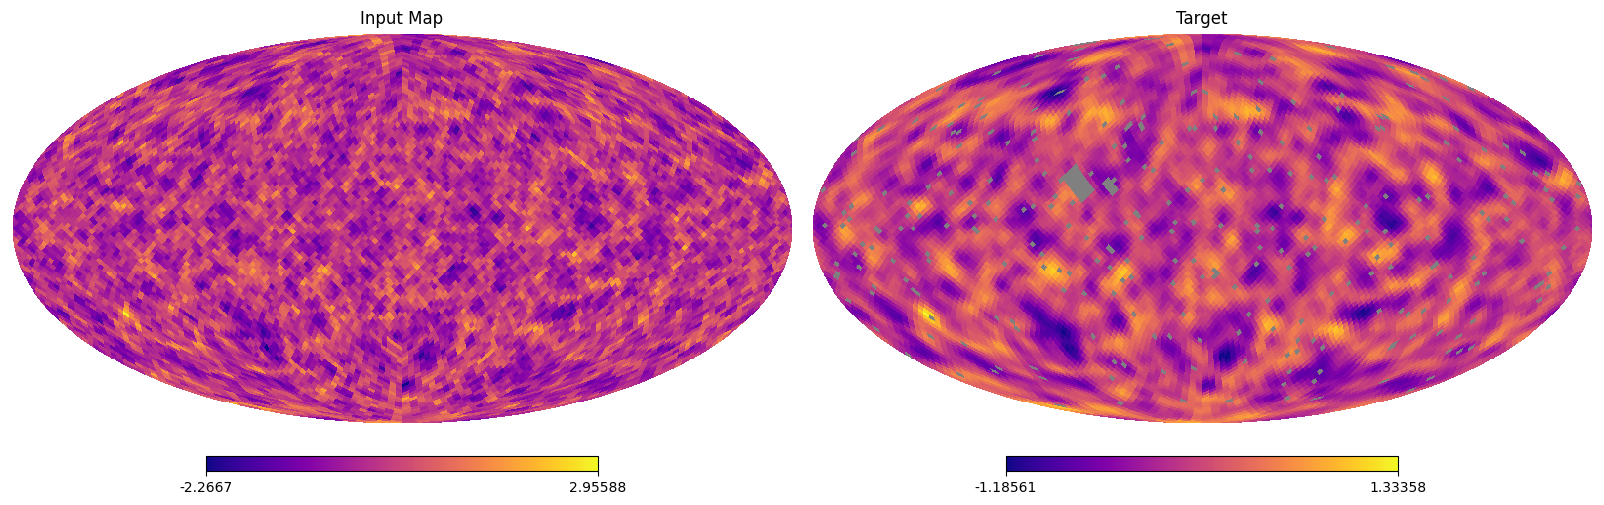

In [10]:
plt.figure(figsize=(16,6))
hp.mollview(heal_im,nest=True,hold=False,sub=(1,2,1),cmap='plasma',title='Input Map')
hp.mollview(nan_target,nest=True,hold=False,sub=(1,2,2),cmap='plasma',title='Target')

In [11]:
u,histo = optimize_scattering_LBFGS(
        target,
        DataClass,
        SO,
        max_iter=100,
        lr=1.0,
        history_size=50,
        verbose=True,
    )

[LBFGS] inner iter 10, loss = 7.039328e+00
[LBFGS] inner iter 20, loss = 9.276508e-01
[LBFGS] inner iter 30, loss = 2.297592e-01
[LBFGS] inner iter 40, loss = 1.074161e-01
[LBFGS] inner iter 50, loss = 6.111540e-02
[LBFGS] inner iter 60, loss = 4.239249e-02
[LBFGS] inner iter 70, loss = 3.021649e-02
[LBFGS] inner iter 80, loss = 2.375582e-02
[LBFGS] inner iter 90, loss = 1.906492e-02
[LBFGS] inner iter 100, loss = 1.649608e-02
[LBFGS] inner iter 110, loss = 1.526710e-02


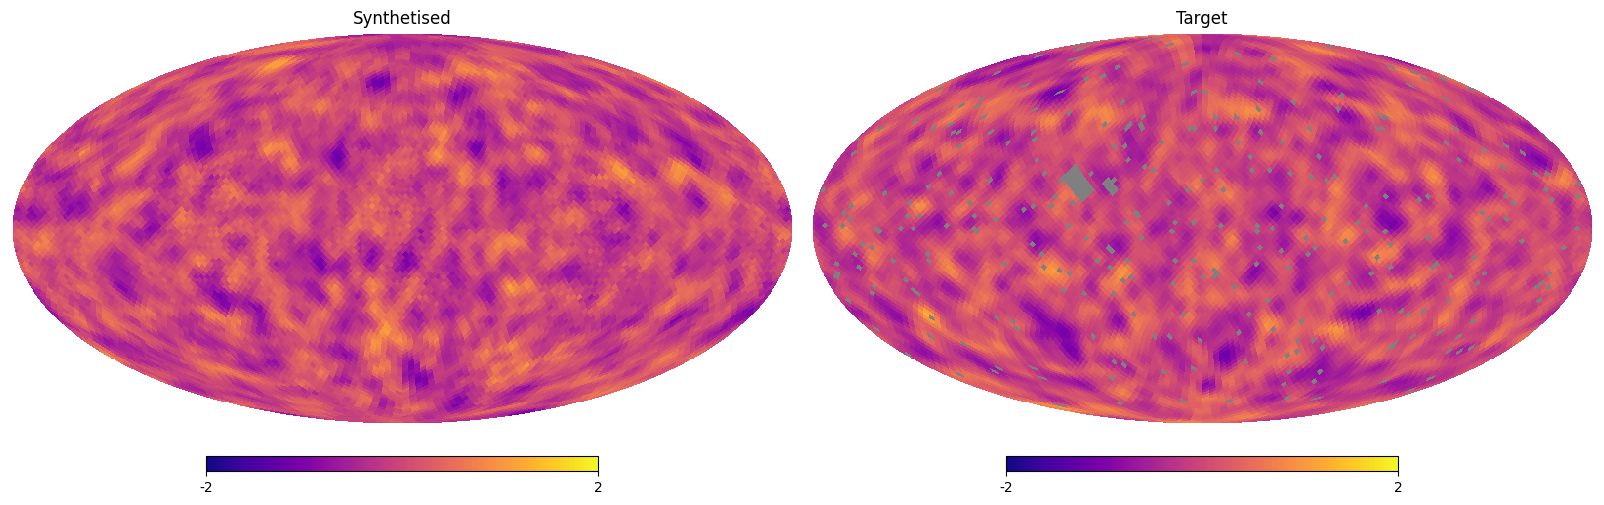

In [12]:
plt.figure(figsize=(16,6))
hp.mollview(u.cpu().numpy(),nest=True,hold=False,sub=(1,2,1),cmap='plasma',title='Synthetised',min=-2,max=2)
hp.mollview(nan_target,nest=True,hold=False,sub=(1,2,2),cmap='plasma',title='Target',min=-2,max=2)

In [15]:
from STL_utils import Gaussianise

g = Gaussianise(target)
g_target=g.forward(target).cpu().numpy()

gu,histo = optimize_scattering_LBFGS(
        g_target,
        DataClass,
        SO,
        nbatch=4,
        max_iter=100,
        lr=1.0,
        print_iter=1,
        history_size=50,
        verbose=True)

u = g.invert(gu)

[LBFGS] inner iter 1, loss = 2.199629e+01
[LBFGS] inner iter 2, loss = 2.199465e+01
[LBFGS] inner iter 3, loss = 2.198034e+01
[LBFGS] inner iter 4, loss = 2.187981e+01
[LBFGS] inner iter 5, loss = 2.173821e+01
[LBFGS] inner iter 6, loss = 2.144117e+01
[LBFGS] inner iter 7, loss = 2.104321e+01
[LBFGS] inner iter 8, loss = 1.944519e+01
[LBFGS] inner iter 9, loss = 1.704804e+01
[LBFGS] inner iter 10, loss = 1.577013e+01
[LBFGS] inner iter 11, loss = 1.511773e+01
[LBFGS] inner iter 12, loss = 1.280734e+01
[LBFGS] inner iter 13, loss = 9.532444e+00
[LBFGS] inner iter 14, loss = 7.888869e+00
[LBFGS] inner iter 15, loss = 6.487378e+00
[LBFGS] inner iter 16, loss = 4.069028e+00
[LBFGS] inner iter 17, loss = 3.167281e+00
[LBFGS] inner iter 18, loss = 2.727047e+00
[LBFGS] inner iter 19, loss = 1.761390e+00
[LBFGS] inner iter 20, loss = 1.140785e+00
[LBFGS] inner iter 21, loss = 2.892967e+00
[LBFGS] inner iter 22, loss = 6.782515e-01
[LBFGS] inner iter 23, loss = 4.595287e-01
[LBFGS] inner iter 2

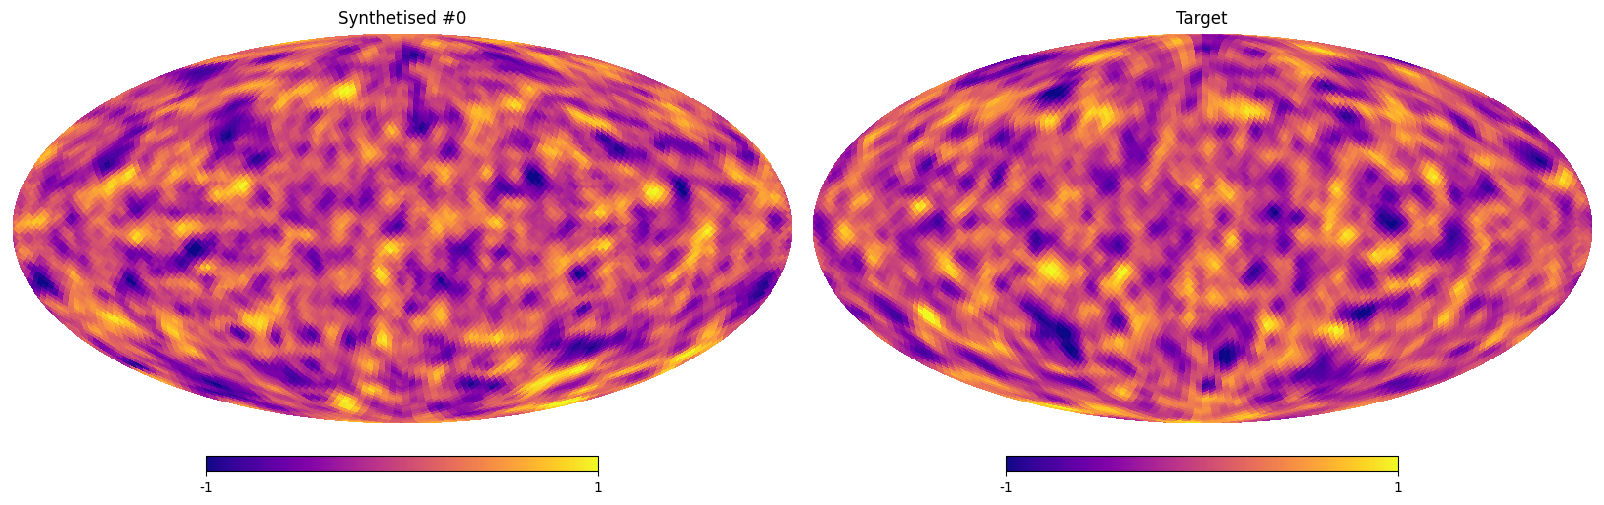

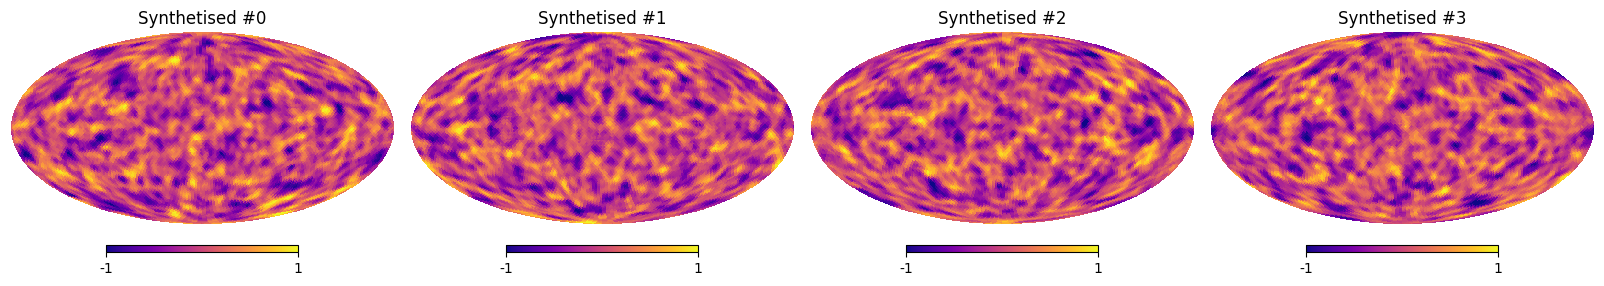

In [16]:
plt.figure(figsize=(16,6))
hp.mollview(u[0].cpu().numpy(),nest=True,hold=False,sub=(1,2,1),cmap='plasma',title='Synthetised #0',min=-1,max=1)
hp.mollview(target,nest=True,hold=False,sub=(1,2,2),cmap='plasma',title='Target',min=-1,max=1)
plt.figure(figsize=(16,4))
for k in range(4):
    hp.mollview(u[k].cpu().numpy(),nest=True,hold=False,sub=(1,4,1+k),
                cmap='plasma',title='Synthetised #%d'%(k),min=-1,max=1)

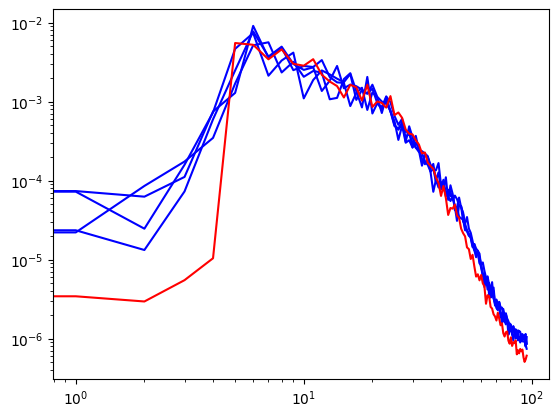

In [17]:
for k in range(4):
    cl1=hp.anafast(hp.reorder(u[k].cpu().numpy(),n2r=True))
    plt.plot(cl1,color='b')
cl2=hp.anafast(hp.reorder(target,n2r=True))
plt.plot(cl2,color='r')
plt.yscale('log')
plt.xscale('log')